In [1]:
# load libs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [2]:
# definition of a simple fc model [11, 32, 64, 1]
class MOGANet(nn.Module):
    def __init__(self):
        super(MOGANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

class MOGADataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [3]:
# define train and test functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # compute output
        outputs = model(x)
        loss = criterion(outputs, y)
        train_loss += loss.item()
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    return train_loss

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            # compute output
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
    test_loss /= len(test_loader)
    return test_loss

In [4]:
# Use CUDA
#use_cuda = torch.cuda.is_available()
device = torch.device("cpu")

random.seed(2020) 
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# load files
moga = pickle.load(open("moga.1124.pkl", "rb"))
x_train, x_test = moga["x_train"], moga["x_test"]
y_train, y_test = moga["y_train"], moga["y_test"]
x_mean, x_std = moga["x_mean"], moga["x_std"]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

In [5]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 4}

# dataloader
train_data = MOGADataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, **params)

test_data = MOGADataset(x_test, y_test)
test_loader = DataLoader(dataset=test_data, **params)

In [6]:
model = MOGANet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

In [7]:
# Training here
for t in range(500):
    train_loss = train(model, device, train_loader, optimizer, criterion) 
    test_loss = test(model, device, test_loader, criterion)
    if t%10 == 0:
        print(t, train_loss, test_loss)
    
    scheduler.step(test_loss)

0 41561.79951450893 17064.875842786816
10 4912.997950892857 4751.409397072988
20 3043.4708401227676 2979.469516423195
30 2587.493134626116 2566.7010537064784
40 2368.476823939732 2337.0326919904037
50 2198.9168706752234 2256.1039938730737
60 2037.407510811942 2045.8355305989583
70 1920.9855355050224 1908.0574332459332
80 1827.966616001674 1797.967608726188
90 1761.6059404296875 1759.6377100835653
100 1715.4111295340401 1696.9055554812358
110 1667.6949478236606 1664.726537417059
120 1636.1306626674107 1633.2547114124036
130 1599.2803205217633 1608.3891857965896
140 1567.909443080357 1553.1547882219427
150 1539.10854296875 1584.5309144459902
160 1508.6625570591518 1510.2007805811215
170 1483.8326665039062 1485.5103458770334
180 1461.0060693359376 1479.2421300879353
190 1442.2249988839285 1470.5338045581834
200 1419.8944181780134 1433.633814145441
210 1406.1452518833705 1403.046456393586
220 1390.5721168387277 1387.799412000125
230 1368.7904418247767 1379.4396986591216
240 1355.7110758231

In [8]:
# save trained model
torch.save(model.state_dict(), 'moga-1124.pth')

In [9]:
model.eval()
Yp = model(x_test)
print("test MSE from criterion")
MSE = criterion(Yp, y_test).item()
print(MSE)

Yp = Yp[:,0].detach().numpy()
y_test = y_test[:,0].detach().numpy()

delta_y = Yp - y_test
RMSE = np.sqrt(MSE)
print("test RMSE of original data")
print(RMSE)

test MSE from criterion
1169.5052490234375
test RMSE of original data
34.19802989973893


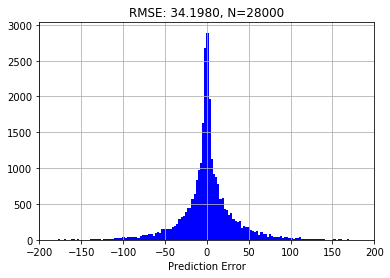

In [10]:
# plot RMSE
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(delta_y, num_bins, facecolor='blue')
plt.xlabel('Prediction Error')
plt.xlim(-200,200)
plt.grid(True)
plt.title('RMSE: %.4f, N=%d' % (RMSE,len(x_test)))
plt.show()

In [11]:
# check mean ans std
print(np.std(y_test))
print(np.mean(y_test))
print(max(y_test), min(y_test))

254.60405
-233.75337
0.0 -1171.5212


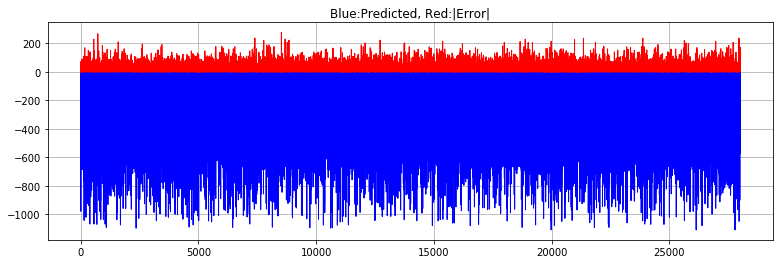

In [12]:
# Viz Yp and |Error|
l = np.array([x for x in range(len(y_test))])
plt.figure(figsize=(13,4))
plt.title("Blue:Predicted, Red:|Error|")
plt.plot(l, Yp, 'b-', linewidth=1)
plt.plot(l, abs(delta_y), 'r-', linewidth=1)
plt.grid(True)
plt.show()

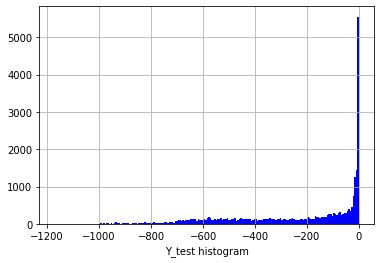

In [13]:
# Viz y_test hist
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(y_test, num_bins, facecolor='blue')
plt.xlabel('Y_test histogram')
plt.grid(True)
plt.show()